# Noun-chunk selection analysis

In [22]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
query_dataframe_folderpath = os.getcwd()+'/../dataframes/query_dataframes_updated_nc_small_cdd/'
tf_model = hub.load(os.path.join(os.getcwd()+ '/../../models/USE_model'))

In [5]:
def get_modified_vectors(vec_data):
    
    new_data = []
    for val in vec_data:
        new_data.append(val)
    
    new_data = np.array(new_data).reshape(-1, 512)
    return new_data

def get_document_vec(text):
    
    return tf_model(text)['outputs'].numpy()[0].reshape(1, -1)

def get_document_index_data(doc_vec, noun_chunk_list):
    
    noun_chunk_vectors = [tf_model(nc)['outputs'].numpy()[0] for nc in noun_chunk_list]
        
    query_distances = cosine_similarity([doc_vec], noun_chunk_vectors)
    noun_chunk_vectors = get_modified_vectors(noun_chunk_vectors)
    max_keyword_cnt = len(noun_chunk_vectors)
    
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0][-max_keyword_cnt:]: 
        
        subtopic_keywords_dict[noun_chunk_list[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)
        
    idx_sim_dict = dict()
    idx = 1
    for key, value in subtopic_keywords_dict:
        idx_sim_dict[str(idx)] = value
        idx += 1
        
    return idx_sim_dict

In [6]:
query_data_dict = dict()

for query_df_filename in os.listdir(query_dataframe_folderpath):

    query_df = pd.read_pickle(query_dataframe_folderpath+query_df_filename)
    
    document_data_list = [] 
    
    for idx, row in query_df.iterrows():
        
        query = row['query']
#         query_vec = tf_model(query)['outputs'].numpy()[0]
        query_data_dict[query] = None
        
        doc_vec = row['doc_repr_vec']
        noun_chunk_list = row['text_tokens']

        document_data_list.append(get_document_index_data(doc_vec, noun_chunk_list))   
        
    query_data_dict[query] = document_data_list

In [23]:
pickle.dump(query_data_dict, open('query_data_dict.pkl', 'wb'))

In [24]:
# query_data_dict = pickle.load(open("query_data_dict.pkl", "rb"))

In [7]:
query_data = query_data_dict['Architekturanalyse']

In [8]:
def get_set_data(dict_data):
    
    set_data = []
    for key, val in dict_data.items():
        set_data.append((int(key), float(val)))
            
    return set_data

def plot_noun_chunk_data(data):
    
    df = pd.DataFrame(get_set_data(data), columns=['idx', 'sim'])
    if len(df.index) < 150:
        ax = df['sim'].plot()
        
        ax.set_xlabel("Rank of a noun chunk")
        ax.set_ylabel("Cosine similarity to the document vector")
#         ax.title("Noun chunk to query similarity anaylsis")

def query_specific_analysis(query):
    
    query_data = query_data_dict[query]
    print(f'Query: {query}')
    for doc_data in query_data:

        plot_noun_chunk_data(doc_data)

Query: Architekturanalyse


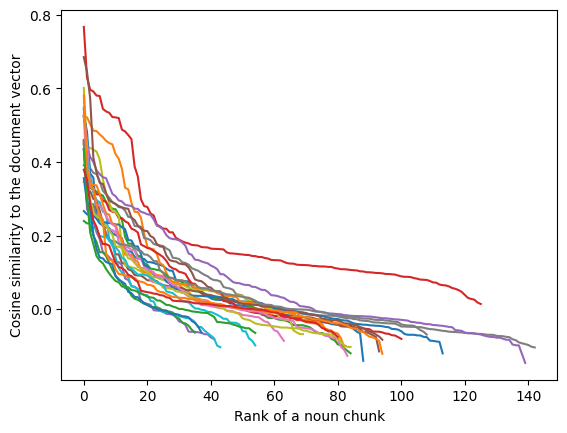

In [9]:
query_specific_analysis('Architekturanalyse')

Query: Cyber Attack


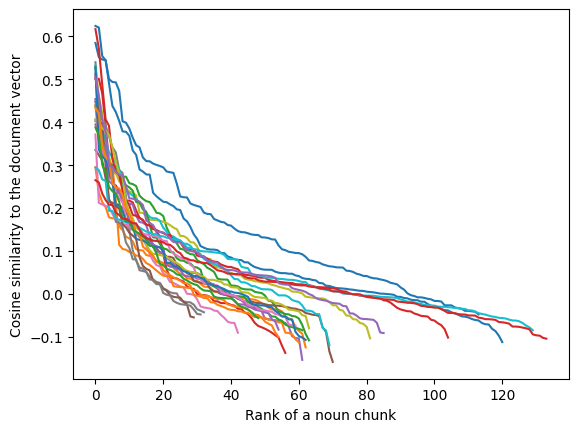

In [10]:
query_specific_analysis('Cyber Attack')

Query: Kryptologie


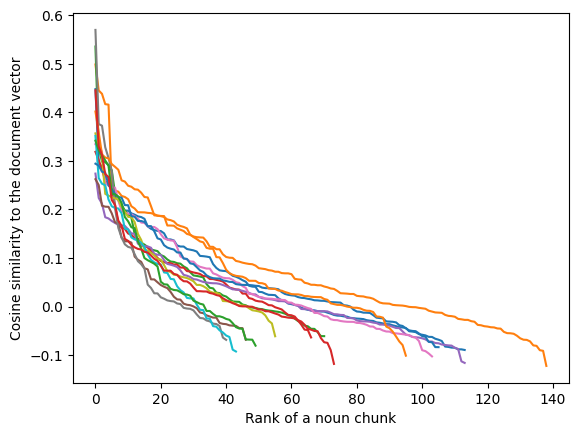

In [11]:
query_specific_analysis('Kryptologie')

Query: Mixed Reality


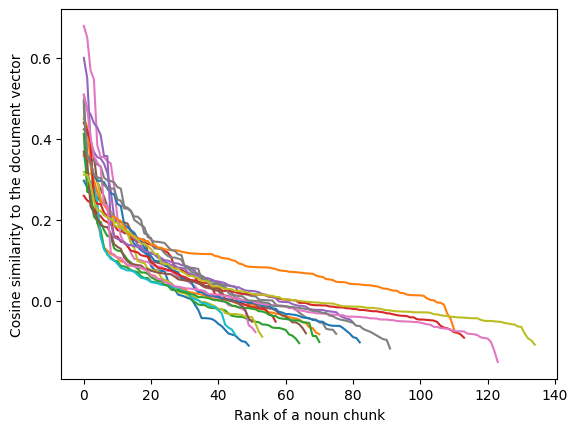

In [12]:
query_specific_analysis('Mixed Reality')

In [13]:
query_data_dict.keys()

dict_keys(['Architekturanalyse', 'Big Data, KI für Analyse', 'Cyber Attack', 'Data Centric Warfare', 'Defense', 'Edge computing', 'IT-Standards', 'Kommunikationsnetze', 'Kryptologie', 'Methode Architektur', 'militärische Entscheidungsfindung', 'Militärische Kommunikation', 'Mixed Reality', 'Quantentechnologie', 'Robotik', 'Satellitenkommunikation', 'Schutz von unbemannten Systemen', 'unbemannte Landsysteme', 'unbemannte Wirksysteme', 'Visualisierung', 'Waffen Systeme', 'Wellenformen und -ausbreitung'])

# Percentile analysis

1. Cut-off rank vs (20, 40, 60, 80) percentile selection per query
2. Mean cut-off rank

In [53]:
complete_ranking_data = []
idx = 0

for query, query_data in query_data_dict.items():
    
    for val in query_data:
        
        idx += 1        
        complete_ranking_data.append({'doc_id': idx, 
                                      'sim_list': [val2 for key, val2 in val.items()]})

In [54]:
noun_chunk_df = pd.DataFrame(complete_ranking_data)
noun_chunk_df.to_pickle('noun_chunk_df.pkl')
noun_chunk_df.sample(3)

,doc_id,sim_list
486,487,"[0.47197953, 0.36029875, 0.28045607, 0.2730534..."
325,326,"[0.2748745, 0.2328982, 0.22208917, 0.20550378,..."
551,552,"[0.37925136, 0.29095638, 0.28826106, 0.2751091..."


In [55]:
noun_chunk_df['noun_chunk_len'] = noun_chunk_df.apply(lambda x:len(x['sim_list']), axis=1)

629

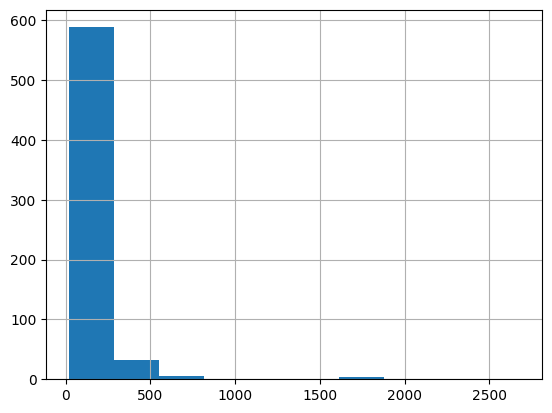

In [56]:
noun_chunk_df['noun_chunk_len'].hist()
len(noun_chunk_df.index)

556


<AxesSubplot:>

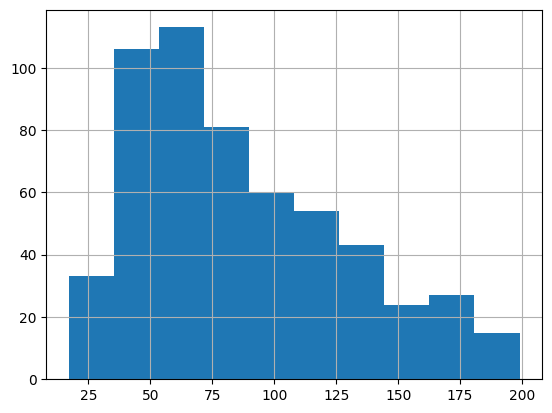

In [57]:
noun_chunk_df = noun_chunk_df[noun_chunk_df['noun_chunk_len'] < 200]
print(len(noun_chunk_df.index))
noun_chunk_df['noun_chunk_len'].hist()

In [58]:
def get_dataframe():
    
    noun_chunk_df = pd.DataFrame(complete_ranking_data)
    noun_chunk_df['noun_chunk_len'] = noun_chunk_df.apply(lambda x:len(x['sim_list']), axis=1)
    noun_chunk_df = noun_chunk_df[noun_chunk_df['noun_chunk_len'] < 200]
    
    return noun_chunk_df


def get_document_under_percentile(sim_list, percent):
    
    cut_off = round(np.percentile(sim_list, percent), 3)
    
    doc_cnt = 0
    for val in sim_list:
        if val >= cut_off:
            doc_cnt += 1
            
    return doc_cnt

In [72]:
noun_chunk_df = get_dataframe()

percentile_values = [10, 20, 30, 40, 50, 60, 70, 80, 90] # _np.arange(99, 100, 0.02)

for percent in range(10, 100, 5):
    
    percent = round(percent, 2)
    noun_chunk_df[f'percentile_{str(100-percent)}'] = noun_chunk_df.apply(lambda x:get_document_under_percentile(x['sim_list'], percent), axis=1)
    
noun_chunk_df.describe()

,doc_id,noun_chunk_len,percentile_90,percentile_85,percentile_80,percentile_75,percentile_70,percentile_65,percentile_60,percentile_55,percentile_50,percentile_45,percentile_40,percentile_35,percentile_30,percentile_25,percentile_20,percentile_15,percentile_10,percentile_5
count,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000
mean,321.116906,86.654676,77.591727,73.246403,69.052158,64.773381,60.476619,56.192446,51.850719,47.631295,43.282374,39.046763,34.739209,30.487410,26.205036,21.955036,17.627698,13.357914,9.059353,4.798561
std,181.713711,41.942898,37.767242,35.632388,33.595943,31.420870,29.374276,27.287736,25.173725,23.107248,20.930286,18.868191,16.824970,14.725042,12.582028,10.551451,8.353877,6.280497,4.207039,2.116192
min,1.000000,17.000000,15.000000,14.000000,13.000000,13.000000,12.000000,11.000000,10.000000,9.000000,9.000000,8.000000,7.000000,6.000000,5.000000,4.000000,4.000000,3.000000,2.000000,1.000000
25%,166.750000,53.750000,47.750000,45.000000,42.000000,40.000000,37.000000,34.750000,32.000000,29.000000,26.750000,24.000000,21.750000,19.000000,16.000000,13.000000,11.000000,8.000000,6.000000,3.000000
50%,323.500000,77.500000,69.000000,66.000000,62.000000,58.000000,54.000000,50.000000,46.500000,43.000000,39.000000,35.000000,31.000000,27.000000,23.000000,20.000000,16.000000,12.000000,8.000000,4.000000
75%,480.250000,114.000000,102.250000,97.000000,91.000000,85.000000,80.000000,74.250000,68.000000,63.000000,57.000000,52.000000,46.000000,40.250000,35.000000,29.000000,23.000000,18.000000,12.000000,6.000000
max,625.000000,199.000000,180.000000,169.000000,160.000000,149.000000,139.000000,130.000000,119.000000,110.000000,99.000000,90.000000,80.000000,70.000000,59.000000,52.000000,40.000000,30.000000,20.000000,10.000000


In [73]:
sim_list_sample = noun_chunk_df.sim_list.values[1]

print(len(sim_list_sample))

for percent in range(10, 100, 10):
    cut_off = round(np.percentile(sim_list_sample, percent), 3)
    
    doc_cnt = 0
    for val in sim_list_sample:
        if val > cut_off:
            doc_cnt += 1
            
    print(f'Percentile: {100-percent}, cut-off: {cut_off}, doc_cnt: {doc_cnt}')
    
sim_list_sample

81
Percentile: 90, cut-off: -0.038, doc_cnt: 72
Percentile: 80, cut-off: -0.021, doc_cnt: 64
Percentile: 70, cut-off: -0.007, doc_cnt: 56
Percentile: 60, cut-off: 0.004, doc_cnt: 50
Percentile: 50, cut-off: 0.015, doc_cnt: 41
Percentile: 40, cut-off: 0.053, doc_cnt: 32
Percentile: 30, cut-off: 0.125, doc_cnt: 24
Percentile: 20, cut-off: 0.264, doc_cnt: 18
Percentile: 10, cut-off: 0.451, doc_cnt: 9


[0.52357,
 0.5214158,
 0.50312954,
 0.48500118,
 0.4839747,
 0.4750224,
 0.46740976,
 0.45738643,
 0.45138517,
 0.4478256,
 0.42103988,
 0.40884838,
 0.3813282,
 0.32993075,
 0.32545692,
 0.28891215,
 0.26441813,
 0.26407573,
 0.24831435,
 0.20490289,
 0.16974592,
 0.16279651,
 0.16257384,
 0.1490762,
 0.12486741,
 0.11952617,
 0.098470315,
 0.07966224,
 0.06825709,
 0.06814934,
 0.06665746,
 0.057276666,
 0.052591152,
 0.047331586,
 0.036643922,
 0.031412527,
 0.029516583,
 0.025387641,
 0.024242109,
 0.023075467,
 0.0152046755,
 0.014608318,
 0.010115739,
 0.009241359,
 0.0081716785,
 0.0066703344,
 0.006495908,
 0.004414046,
 0.004363793,
 0.0042548645,
 0.001924349,
 0.0014821887,
 0.0014675446,
 0.000540711,
 -0.000874822,
 -0.0029328428,
 -0.007170962,
 -0.007400141,
 -0.011962963,
 -0.015171824,
 -0.018204631,
 -0.019553114,
 -0.019667478,
 -0.020196926,
 -0.021188337,
 -0.022051385,
 -0.022455439,
 -0.030004336,
 -0.030208863,
 -0.030284494,
 -0.035611477,
 -0.037225656,
 -0.03

In [74]:
percentile_str = [f'percentile_{str(100-percent)}' for percent in range(10, 100, 10)]

mean_vals = list(noun_chunk_df[percentile_str].mean())
min_vals = list(noun_chunk_df[percentile_str].min())
max_vals = list(noun_chunk_df[percentile_str].max())

In [75]:
final_data = []

for idx in range(len(mean_vals)):
    final_data.append((percentile_str[idx], mean_vals[idx], min_vals[idx], max_vals[idx]))

In [76]:
meta_df = pd.DataFrame(final_data, columns=['Percentile', 'Mean', 'Min', 'Max'])
meta_df

,Percentile,Mean,Min,Max
0,percentile_90,77.591727,15,180
1,percentile_80,69.052158,13,160
2,percentile_70,60.476619,12,139
3,percentile_60,51.850719,10,119
4,percentile_50,43.282374,9,99
5,percentile_40,34.739209,7,80
6,percentile_30,26.205036,5,59
7,percentile_20,17.627698,4,40
8,percentile_10,9.059353,2,20


<AxesSubplot:>

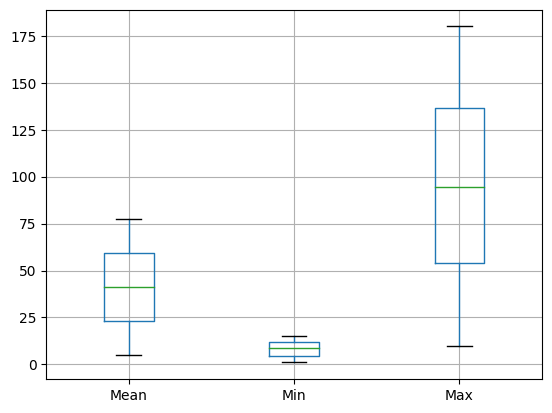

In [64]:
meta_df.boxplot()

In [5]:
A = [[1, 2, 3], [2, 4, 6], [3, 6]]
B = [1, 2, 3]

B != [1, 2, 3]

False

In [65]:
complete_ranking_data = list(set(complete_ranking_data))
sorted(complete_ranking_data)

percentile_values = np.arange(98, 100, 0.2)

for percentile in percentile_values:
    
    print(round(np.percentile(complete_ranking_data, percentile), 3))

TypeError: unhashable type: 'dict'